# Introduction to PyTorch with NLP

PyTorch is a popular open-source deep learning framework developed by Facebook’s AI Research lab that provides flexibility and dynamic computational graphs, making it highly favored for research and production purposes. With its intuitive interface, PyTorch allows developers to build and train complex neural networks with ease.

A computation graph is a network of nodes where each node represents an operation or variable, and the edges represent data dependencies between operations. Dynamic computation graphs are particularly useful in Natural Language Processing (NLP), where the input data, such as sentences or sequences, can vary in length and structure. PyTorch’s dynamic nature allows the graph to adapt to different input shapes and sizes, making it easier to handle complex tasks like sequence-to-sequence learning, attention mechanisms, and more.

### Documentation for PyTorch
[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

# Tensors
Tensors are the core data structure in PyTorch, analogous to arrays and matrices in NumPy but with additional capabilities. A tensor is a multi-dimensional array that serves as the basic building block for deep learning models. They can hold data of various types, such as integers, floating-point numbers, or even complex numbers, and can operate on GPUs, making them highly efficient for large-scale computations.

In [1]:
import torch
import numpy as np

In [2]:
a = torch.ones(3,3)
print(a)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [3]:
b = a.numpy()
print(b)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [4]:
# Now changing the value of 'a' will also change the value of 'b'
a.add_(1)
print(a)
print(b)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


The code snippet demonstrates the concept of in-place operations and tensor aliasing in PyTorch. When you perform an in-place operation (e.g., a.add_(1)), it modifies the original tensor a directly without creating a new tensor. If another tensor, b, shares the same underlying data as a (i.e., they are aliases), then modifying a will also affect b.

## Location of tensors
In PyTorch, the location of tensors—whether on a CPU or GPU—directly impacts the performance and functionality of your code. Tensors can be stored on different devices, and operations on tensors must be performed on the same device to avoid errors and inefficiencies.

## Importance of Tensor Location Management

1.	Performance Optimization: Moving tensors to the GPU can significantly accelerate computations, as GPUs are designed to handle matrix operations much more efficiently than CPUs. This is especially important for training deep learning models where large amounts of data and complex operations are involved.
2.	Error Prevention: PyTorch requires all tensors involved in a computation to be on the same device. If operations are attempted between tensors on different devices (e.g., adding a CPU tensor to a GPU tensor), it will result in a runtime error like RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!. Properly managing tensor locations ensures compatibility and prevents such errors.
3.	Memory Management: GPUs have limited memory compared to CPUs. Properly managing tensor locations helps efficiently utilize GPU memory and avoid issues like out-of-memory errors. Moving tensors to the appropriate device only when needed can help balance memory usage across devices.


Below is a code snippet explaining critical aspects of tensor location management in PyTorch, highlighting performance benefits and common pitfalls.

In [5]:
import torch

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a tensor on the CPU
x_cpu = torch.tensor([1.0, 2.0, 3.0])

# Create a tensor on the GPU (if available)
x_gpu = torch.tensor([4.0, 5.0, 6.0], device=device)

# Demonstrating Performance Optimization by moving CPU tensor to GPU
# Moving x_cpu to the GPU can accelerate computations
x_cpu = x_cpu.to(device)

# Performing operations on the same device (GPU in this case)
result = x_cpu + x_gpu
print("Result on GPU:", result)

# Demonstrating Error Prevention
# This will cause an error if x_cpu is not moved to the GPU
try:
    # Attempting an operation between tensors on different devices
    x_cpu = torch.tensor([1.0, 2.0, 3.0])  # Back on CPU
    error_result = x_cpu + x_gpu
except RuntimeError as e:
    print("Error:", e)

# Demonstrating Memory Management
# Moving the result back to the CPU to free up GPU memory
result = result.to("cpu")
print("Result moved back to CPU:", result)

Result on GPU: tensor([5., 7., 9.], device='cuda:0')
Error: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
Result moved back to CPU: tensor([5., 7., 9.])


## Broadcasting

Broadcasting is a method used in PyTorch (and other libraries like NumPy) that allows arithmetic operations on tensors of different shapes by automatically expanding the smaller tensor(s) to match the shape of the larger one. Broadcasting follows a set of rules to make the tensors compatible without explicitly copying data, allowing efficient computation even when the shapes initially do not match.

## How is Broadcasting Done?
Broadcasting follows a set of rules to determine how to expand the smaller tensor to match the shape of the larger one:

1.	Alignment from the Right: Tensors are aligned from the right when comparing their shapes. For instance, to broadcast (4, 3, 2) with (3, 2), align as follows:

$$
(4, 3, 2) \\
( , 3, 2)
$$

2.	Dimension Compatibility: Two dimensions are compatible if:
-	They are equal.
-	One of them is 1. In this case, the dimension with 1 is stretched to match the other dimension.
3.	Expansion: Dimensions with 1 are virtually expanded to match the corresponding dimension of the other tensor without physically copying data.

Consider two tensors A and B:

- Let A be of shape (3, 1):

$$
A =
\begin{bmatrix}
1 \\
2 \\
3
\end{bmatrix}
$$

- Let B be of shape (1, 4):

$$
B =
\begin{bmatrix}
10 & 20 & 30 & 40
\end{bmatrix}
$$

When performing the operation A + B, broadcasting expands A and B to a compatible shape (3, 4):

1.	Expand A along columns:

$$
A_{\text{expanded}} =
\begin{bmatrix}
1 & 1 & 1 & 1 \\
2 & 2 & 2 & 2 \\
3 & 3 & 3 & 3
\end{bmatrix}
$$

2.	Expand B along rows:

$$
B_{\text{expanded}} =
\begin{bmatrix}
10 & 20 & 30 & 40 \\
10 & 20 & 30 & 40 \\
10 & 20 & 30 & 40
\end{bmatrix}
$$

Now, you can perform element-wise addition:

$$
A + B =
\begin{bmatrix}
1+10 & 1+20 & 1+30 & 1+40 \\
2+10 & 2+20 & 2+30 & 2+40 \\
3+10 & 3+20 & 3+30 & 3+40
\end{bmatrix} =
\begin{bmatrix}
11 & 21 & 31 & 41 \\
12 & 22 & 32 & 42 \\
13 & 23 & 33 & 43
\end{bmatrix}
$$

In [6]:
import torch

# 2D tensor (batch of vectors)
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("2D Tensor:")
print(tensor_2d)

# 1D tensor (vector)
tensor_1d = torch.tensor([10, 20, 30])
print("1D Tensor:")
print(tensor_1d)

# Broadcasting
result = tensor_2d + tensor_1d
print("Result after broadcasting:")
print(result)

2D Tensor:
tensor([[1, 2, 3],
        [4, 5, 6]])
1D Tensor:
tensor([10, 20, 30])
Result after broadcasting:
tensor([[11, 22, 33],
        [14, 25, 36]])


In [7]:
import torch

# Tensor with shape (2, 3)
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("2D Tensor:")
print(tensor_2d)

# Tensor with shape (2, 2) - This is incompatible for broadcasting
tensor_incompatible = torch.tensor([[10, 20], [30, 40]])
print("Incompatible Tensor:")
print(tensor_incompatible)

try:
    result = tensor_2d + tensor_incompatible
except RuntimeError as e:
    print(f"Error: {e}")

2D Tensor:
tensor([[1, 2, 3],
        [4, 5, 6]])
Incompatible Tensor:
tensor([[10, 20],
        [30, 40]])
Error: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1


## Let's take an example of Multi-Class Classification

We will explore multi-class classification using a real-world dataset of tweets annotated with various emotions. The goal is to build a model that can accurately classify the emotion expressed in a given tweet into one of several categories, such as sadness, enthusiasm, anger, joy, and others.

The dataset tweet_emotions.csv contains three columns:

1.	tweet_id: A unique identifier for each tweet.
2.	sentiment: The emotion or sentiment expressed in the tweet. This is the target variable with multiple classes, such as empty, sadness, enthusiasm, neutral, and others.
3.	content: The text of the tweet, representing the input features used for classification.

## Loading the Dataset

A DataFrame is a two-dimensional, tabular data structure commonly used in data manipulation and analysis. In Python, the most popular implementation of DataFrames is provided by the Pandas library.

In this step, we load the dataset containing tweets and their associated emotions using the pandas library. The dataset is stored in a CSV file, which we read into a DataFrame for easier manipulation and analysis.

In [8]:
import torch
import torch.nn as nn
import random
import numpy as np
from collections import Counter
import re
import html
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [10]:
import pandas as pd

# Load the CSV file
file_path = 'tweet_emotions.csv'
df = pd.read_csv(file_path)

## Understanding the Data

In this step, we examine the basic characteristics of the dataset. We'll check the structure of the DataFrame, including the column names, data types, and summary statistics. This helps us understand the kind of data we are working with and identify any preprocessing steps that might be necessary.

In [255]:
# Display basic information about the DataFrame
print("DataFrame Info:")
print(df.head())

DataFrame Info:
     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


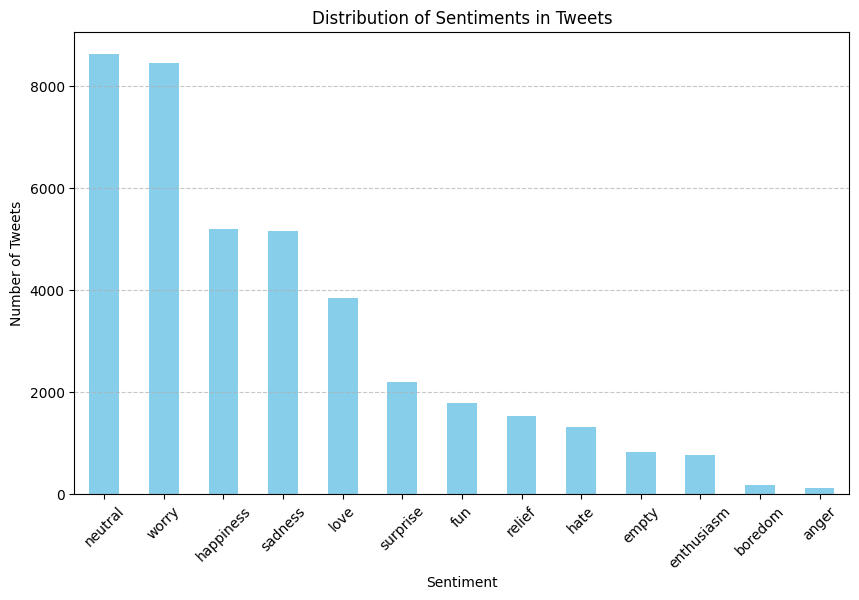

In [256]:
import matplotlib.pyplot as plt

# Count the number of tweets for each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiments in Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Label Encoding

Label encoding is a technique used to convert categorical data into numerical values. In machine learning, categorical variables (such as class labels) need to be transformed into a numerical format so that they can be used by ML models, which typically work with numerical data.

In [257]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


def encode_labels(temp_df, label_column='sentiment'):
    encoder = OneHotEncoder(sparse=False)
    one_hot_encoded = encoder.fit_transform(df[[label_column]])
    one_hot_encoded_int = one_hot_encoded.astype(int)
    one_hot_vectors = one_hot_encoded_int.tolist()
    temp_df[label_column + '_one_hot'] = one_hot_vectors

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the sentiment column
    temp_df[label_column + '_label'] = label_encoder.fit_transform(df[label_column])

    return one_hot_vectors, encoder.get_feature_names_out([label_column]), label_encoder

In [258]:
temp_df = df

one_hot_vectors, feature_names, label_encoder = encode_labels(temp_df, 'sentiment')

# Display the DataFrame
print(temp_df[['content', 'sentiment', 'sentiment_label', 'sentiment_one_hot']].head())

                                             content   sentiment  \
0  @tiffanylue i know  i was listenin to bad habi...       empty   
1  Layin n bed with a headache  ughhhh...waitin o...     sadness   
2                Funeral ceremony...gloomy friday...     sadness   
3               wants to hang out with friends SOON!  enthusiasm   
4  @dannycastillo We want to trade with someone w...     neutral   

   sentiment_label                        sentiment_one_hot  
0                2  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1               10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
2               10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
3                3  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
4                8  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]  


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Where One-Hot Encoding is Useful:

1.	Input Features for Machine Learning Models: One-hot encoding is essential when categorical features are used as input to models like Logistic Regression, Neural Networks, or SVMs. It prevents models from assuming any ordinal relationship between categories.
2.	Neural Networks with Softmax and Cross-Entropy Loss: One-hot encoding is required for multi-class classification tasks where the model outputs a probability distribution. It allows for the correct computation of cross-entropy loss by comparing the predicted probabilities against the true distribution.

Where Class Label Encoding is Useful:

1.	Target Variables in Classification: Label encoding is commonly used for encoding target variables in classification tasks, converting categories into integers that models like Decision Trees, Random Forests, and SVMs can interpret correctly without assuming ordinal relationships.
2.	Tree-Based Models: Label encoding works well with models like Decision Trees, Random Forests, and Gradient Boosted Trees, as these models treat the labels as distinct categories and do not rely on any numerical order implied by the encoding.

### We will be using class label encoding

In [259]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

## Preprocessing

Preprocessing is a critical step in Natural Language Processing (NLP) that significantly influences the performance and accuracy of machine learning models. It involves transforming raw text data into a structured format that algorithms can easily interpret and analyze. The primary goal of preprocessing is to clean, normalize, and organize textual data, removing noise and irrelevant details that could mislead the model.

In [260]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with a single space
    s = re.sub(r"\s+", ' ', s)
    # Replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

## Tokenization

Tokenization is a fundamental preprocessing step in Natural Language Processing (NLP) that involves breaking down text into smaller units called tokens, typically words, subwords, or characters. This step is crucial because it transforms raw text into a structured format that can be effectively processed and understood by machine learning models. Tokenization helps capture the syntactic and semantic structure of the text, allowing models to analyze the underlying patterns of language.

In this notebook, we are using word-based tokenization for simplicity. Most of the SOTA models these days use subword tokenization which you will study in future lectures.

In [261]:
def tokenize_df(df, label_column='sentiment'):

    def tokenize_text(text):
        arr = [word for word in text.lower().split()]
        return arr

    df['tokenized'] = df['processed_text'].apply(tokenize_text)

    return df

In [262]:
from sklearn.model_selection import train_test_split

# Preprocess
df['processed_text'] = df['content'].apply(preprocess_string)

drop_columns = ['tweet_id']
final_df = df.drop(drop_columns, axis=1)

# Train-test split
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=42, stratify=df['sentiment'])

# Tokenize the text in each split
train_df = tokenize_df(train_df)
val_df = tokenize_df(val_df)

# Display the results
print("Train DataFrame:\n", train_df.head())

Train DataFrame:
       sentiment                                            content  \
25630   neutral                       @dizzyupthegirl thankyooooou   
23955   neutral           just watching ncis complete first season   
7128      worry                      @blkademic what's the matter?   
15097      hate  i donbt like to peel prawns, i also dont like ...   
8605    neutral  damn... people contain gluten so now i cant be...   

                             sentiment_one_hot  sentiment_label  \
25630  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]                8   
23955  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]                8   
7128   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]               12   
15097  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]                6   
8605   [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]                8   

                                          processed_text  \
25630                        dizzyupthegirl thankyooooou   
23955           just watching ncis com

## Vocabulary Map

-	Numerical Representation: PyTorch models, like all machine learning models, require numerical input. Raw text cannot be directly fed into a model because it consists of characters and words, which are non-numeric. Vocabulary mapping converts text tokens into numerical indices. This numerical representation allows PyTorch models to process and learn from text data.
-	Special Tokens: Special tokens are crucial for handling various aspects of text data in NLP models. They include:
 -	Padding Token (<PAD>): Used to ensure that all sequences in a batch have the same length. Padding tokens are added to the sequences to standardize their length, which is essential for batch processing. For example, if you have sentences of varying lengths, padding tokens help to make them uniform in length.
 -	Unknown Token (UNK): Represents words that are not found in the vocabulary. When a token is encountered that was not seen during training, it is replaced with the UNK token. This ensures that the model can handle out-of-vocabulary words gracefully.
-	Vocabulary Map: PyTorch’s Dataset and DataLoader classes require inputs to be in tensor format for efficient training and evaluation. The vocab map allows for converting text data into numerical tensors, which are compatible with PyTorch’s data structures. This process involves:
-	Mapping Tokens to Indices: Each unique token is assigned a numerical index based on its frequency and importance. Special tokens are typically assigned specific indices that are reserved for them.
-	Handling Padding and Unknown Tokens: Special tokens like <PAD> and UNK are included in the vocabulary map to handle padding and out-of-vocabulary scenarios. These tokens help manage sequence length variations and unknown words, ensuring the model can process and learn from text data effectively.

In [263]:
def generate_vocab_map(df, cutoff=2):
    # Initialize vocab with special tokens for padding and unknown
    vocab = {"<PAD>": 0, "UNK": 1}
    reversed_vocab = None

    # Flatten the list of tokenized words and count their occurrences
    word_counts = {}
    for tokens in df["tokenized"]:
        for word in tokens:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    # Assign unique indices to words that appear more than 'cutoff' times
    word_idx = len(vocab)
    for word, count in word_counts.items():
        if count > cutoff:
            vocab[word] = word_idx
            word_idx += 1

    # Generate the reversed vocab map
    reversed_vocab = {idx: word for word, idx in vocab.items()}

    return vocab, reversed_vocab

In [264]:
train_vocab, reverse_vocab = generate_vocab_map(train_df)

In [265]:
count = 0
for key, value in train_vocab.items():
  print(f"{key}: {value}")
  count += 1
  if count == 10:
    break

<PAD>: 0
UNK: 1
just: 2
watching: 3
complete: 4
first: 5
season: 6
whats: 7
the: 8
matter: 9


## Create Dataset for pytorch
- PyTorch’s Dataset class allows you to define your own custom preprocessing steps, such as tokenization, padding, normalization, and augmentation, directly within the dataset class.
- This ensures that your data is processed consistently and efficiently at the time of loading, making it easy to experiment with different preprocessing strategies.
- The Dataset class works seamlessly with PyTorch’s DataLoader, which handles batching, shuffling, and parallel data loading using multiple workers.


In [327]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, vocab, df, max_length=30):
        self.vocab = vocab
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]
        tokenized = row["tokenized"]

        # Tokenize and pad/truncate to max_length
        tokenized_word_tensor = torch.tensor(
            [self.vocab.get(word, self.vocab.get('<unk>', 0)) for word in tokenized[:self.max_length]],
            dtype=torch.long
        )

        # Pad sequence to max_length if necessary
        if len(tokenized_word_tensor) < self.max_length:
            pad_length = self.max_length - len(tokenized_word_tensor)
            tokenized_word_tensor = torch.cat(
                [tokenized_word_tensor, torch.zeros(pad_length, dtype=torch.long)]
            )

        # Get the label as a tensor
        label = torch.tensor(row["sentiment_label"], dtype=torch.long)

        return tokenized_word_tensor, label

In [328]:
train_dataset = SentimentDataset(train_vocab, train_df)
val_dataset = SentimentDataset(train_vocab, val_df)

## Sampler

1.	Improves Model Generalization:
	- By shuffling the data each epoch, RandomSampler helps prevent the model from learning the order of the data, which can cause overfitting.
	-	This randomness forces the model to learn generalized patterns rather than memorizing the sequence of data points.
2.	Ensures Data Variability in Batches:
	-	Random sampling ensures that each batch during training is different, which exposes the model to a diverse set of examples more frequently.
	-	Diverse batches help the model learn from all parts of the dataset more evenly, improving the training dynamics.
3.	Avoids Bias in Batch Formation:
	-	Without random sampling, data points might appear in a biased order, potentially causing the model to train unevenly.
	-	By shuffling the order, RandomSampler prevents any potential bias related to the order in which data was originally sorted or labeled.
4.	Sampling with Replacement:
	-	You can set replacement=True to allow resampling of data points within the same epoch, which is useful for tasks like bootstrapping.
	-	This setting is particularly valuable when dealing with imbalanced datasets or when implementing specific sampling strategies.

In [329]:
train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)

## Padding

In natural language processing (NLP) and deep learning, sequences such as sentences can vary in length. However, most deep learning models, especially those using batch processing, require input sequences of a fixed size. To accommodate this, padding is applied to sequences to make them of uniform length. Padding involves adding extra tokens (usually zeros) to sequences that are shorter than the desired length. This step is essential when converting sequences into tensors of consistent size for batch processing in frameworks like PyTorch.

### Types of padding
1. Front Padding:
  
  In front padding, also known as left padding, the padding tokens are added at the beginning of the sequence. For instance, if you want a sequence to be of length 10 and the original sequence is only 7 tokens long, you would add 3 padding tokens at the start.
  
  Example: [PAD, PAD, PAD, word1, word2, ..., word7]
  
  Use Case: Front padding is commonly used in some NLP tasks where aligning the end of sequences might be beneficial for models like RNNs, which process data sequentially from left to right.
2. Back Padding:
  
  In back padding, also known as right padding, the padding tokens are added at the end of the sequence. This is the most common approach since it keeps the original sequence structure intact and places the padding at the end.
  
  Example: [word1, word2, ..., word7, PAD, PAD, PAD]
  
  Use Case: Back padding is widely used in NLP tasks and is the default for many models because it maintains the natural order of the sequence. It’s particularly useful in models like Transformers, where positional encodings are used.

### Problems with Padding

1. Impact on Mean and Other Calculations:
  
  When sequences are padded excessively, the padding tokens (often zeros) can distort calculations like the mean or sum across the sequence dimension. For instance, if you calculate the mean of a sequence that includes many padding tokens, the mean value may be artificially lowered due to the zeros, which do not represent meaningful data.
  
  Example: Consider a sequence [5, 6, 7, 0, 0, 0]. The mean of the original sequence without padding would be (5 + 6 + 7)/3 = 6, but with padding, the mean becomes (5 + 6 + 7 + 0 + 0 + 0)/6 = 3, which misrepresents the true average value.

2. Increased Computational Load:

  Padding increases the size of the input tensor, which can lead to unnecessary computations, especially if a large portion of the input tensor is padding. This can slow down training and increase memory usage without contributing to learning.
  
  Example: A model processing a sequence of length 50, where 30 tokens are padding, spends computational resources processing the padding, which does not provide useful information.

3. Gradient Flow Issues:
  
  Padding can also affect gradient flow, particularly in models like RNNs, where padded tokens might cause gradients to vanish or explode, especially if the model mistakenly learns to focus on the padding.

In [309]:
def pad_sequences_end(batch, max_length=50):
    padded_batch = torch.zeros((len(batch), max_length), dtype=torch.long)
    for i, seq in enumerate(batch):
        seq_len = min(len(seq), max_length)
        padded_batch[i, :seq_len] = seq[:seq_len]
    return padded_batch

## Collate Functions:
*	The collate_fn parameter allows for custom logic when merging samples into a batch, such as padding sequences to the same length for NLP tasks.
*	This customization is vital for working with variable-length data and ensures consistent tensor shapes across batches.

In [339]:
def collate_fn(batch, max_length=30):
    texts, labels = zip(*batch)
    padded_texts = pad_sequences_end(texts, max_length)
    labels = torch.stack(labels, dim=0)
    return padded_texts, labels


## Dataloader

DataLoader is a class in PyTorch’s torch.utils.data module that helps to load data from a dataset in an efficient manner. It manages batching, shuffling, parallel data loading, and more, which are essential for training deep learning models.
-	Batching: Splits the dataset into small batches of data, making it easier for the model to process and update weights iteratively.
-	Shuffling: Allows shuffling of the data to prevent models from learning the order of samples, enhancing model generalization.
-	Parallel Data Loading: Supports loading data in parallel using multiple CPU workers, which speeds up the data loading process.
-	Custom Sampling: Works seamlessly with custom samplers like RandomSampler to control how data points are selected.

In [340]:
train_iterator = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, collate_fn=collate_fn)
val_iterator = DataLoader(val_dataset, batch_size=128, sampler=val_sampler, collate_fn=collate_fn)

In [341]:
for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    # print(x)
    # print(y)
    break

x: torch.Size([128, 30])
y: torch.Size([128])


## Model Architecture:

- Embedding Layer (nn.Embedding): Converts word indices to dense vectors.
 - Fully Connected Layer 1 (nn.Linear): Maps flattened embeddings to hidden features, followed by ReLU activation.
 - Fully Connected Layer 2 (nn.Linear): Outputs logits for each of the 13 classes.
- Optimizer:

 - Adam Optimizer (optim.Adam): Used with a learning rate of 0.001 for adaptive gradient updates.
- Loss Function:

 - CrossEntropyLoss (nn.CrossEntropyLoss): Suitable for multi-class classification tasks.
- Hyperparameters:

 - Embedding Size: 128
 - Hidden Size: 128
 - Output Size: 13 classes
 - Max Sequence Length: 50
 - Batch Size: 128 (used in the DataLoader)
 - Learning Rate: 0.001
 - Patience for Early Stopping: 5 epochs

### Masking

Masking is a technique used in deep learning to handle variable-length sequences, particularly when padding is involved. When sequences are padded to ensure uniform length across a batch, the padding tokens (typically zeros) do not carry meaningful information. However, if these padded tokens are processed by the model, they can distort the learning process, affecting the model's accuracy and efficiency. Masking is used to instruct the model to ignore these padded tokens during certain computations, such as in attention mechanisms, loss calculations, and predictions.

### Why Masking is Important
1. Avoiding Padding Influence: Without masking, the model might learn to treat padding tokens as meaningful, which can lead to incorrect learning and biased predictions.

2. Efficient Computation: By masking out padding tokens, the model can focus its computations on meaningful data, thereby improving efficiency and reducing unnecessary calculations.

3. Correct Loss Calculation: In sequence-to-sequence models (e.g., in translation tasks), padding should not contribute to the loss. Masking ensures that the loss is computed only over the actual data, not the padding.

4. Improved Gradient Flow: By masking, the gradients during backpropagation are computed only for the actual tokens, which helps in preventing issues like vanishing or exploding gradients, especially in recurrent models.

In [449]:
# Model definition

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class FeedforwardModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = x.float()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Early Stopping

Early Stopping is a popular regularization technique used in machine learning to prevent overfitting during the training of models, particularly neural networks. It works by monitoring the performance of the model on a validation set and halting the training process when the model’s performance starts to degrade, indicating that further training would lead to overfitting rather than improvements.

In [433]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if score < self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## Softmax and Cross-Entropy with One-Hot Encoding

### Softmax
Softmax is a mathematical function used in machine learning, particularly in classification tasks. It converts raw scores (logits) from a model into probabilities by normalizing them. The output is a probability distribution where each value represents the likelihood of each class, and all probabilities sum up to 1.


Formula:
For a vector $ z = [z_1, z_2, \ldots, z_n] $, the softmax function is given by:
$$
 \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

where  e  is the base of the natural logarithm, $ z_i $ is the raw score for class  i , and the denominator sums over all classes to normalize the scores.

Softmax is commonly used in the final layer of a classification model to output probabilities for each class.

### Cross-Entropy

Cross-entropy is a loss function used to measure the difference between two probability distributions. In classification tasks, it measures how well the predicted probability distribution (obtained from softmax) matches the true distribution (actual class labels).

Formula:
For a single data point, cross-entropy loss  L  is given by:
$$
 L = -\sum_{i} y_i \log(p_i)
$$
where:

- $y_i$ is the true probability (usually 1 for the correct class and 0 for others),
- $p_i$ is the predicted probability for class  i .

Usage: Cross-entropy is used to train classification models by minimizing the difference between the predicted probabilities and the actual labels. It is particularly effective in guiding the model to produce accurate probability distributions.

### How softmax and cross-entropy works

One-Hot Encoding: Suppose the true sentiment labels are as follows:

- Positive: [1, 0, 0]
- Neutral: [0, 1, 0]
- Negative: [0, 0, 1]

Model Output (Softmax Probabilities):
- For an input, the model predicts probabilities: [0.7, 0.2, 0.1], indicating a high confidence in the “Positive” class.
Cross-Entropy Loss Calculation:
- If the true label is “Positive” ([1, 0, 0]), the cross-entropy loss is calculated using:

$$
\text{Loss} = -\sum (\text{True Label} \times \log(\text{Predicted Probabilities}))
$$

- Substituting the values:

$$
\text{Loss} = -(1 \times \log(0.7) + 0 \times \log(0.2) + 0 \times \log(0.1)) = -\log(0.7)
$$

- This loss indicates how well the predicted probabilities match the true one-hot encoded distribution, guiding the model to improve.


### Some more precautions with softmax
While working with softmax in pytorch, the dim parameter dictates across which dimension the softmax operations is done. Basically, the softmax operation will transform your input into a probability distribution i.e. the sum of all elements will be 1. The below example shows the difference between using dim=0 or dim=1 for a 2D input tensor (supposing the first dimension for the batch size, and the second for the number of classes).

In [407]:
# input tensor of dimensions B x C, B = number of batches, C = number of classes.
inputs = torch.rand(size=(4, 4), dtype=torch.float32)
soft_dim0 = torch.softmax(inputs, dim=0)
soft_dim1 = torch.softmax(inputs, dim=1)
print('**** INPUTS ****')
print(inputs)
print('**** SOFTMAX DIM=0 ****')
print(soft_dim0)
print('**** SOFTMAX DIM=1 ****')
print(soft_dim1)

**** INPUTS ****
tensor([[2.6498e-01, 3.8158e-01, 7.0097e-03, 1.2189e-02],
        [5.3601e-01, 3.9409e-02, 5.9137e-01, 7.1151e-01],
        [2.7660e-01, 5.9438e-01, 4.6486e-01, 9.5549e-01],
        [4.2655e-01, 6.7383e-01, 2.3276e-04, 3.8788e-01]])
**** SOFTMAX DIM=0 ****
tensor([[0.2223, 0.2333, 0.1863, 0.1421],
        [0.2915, 0.1657, 0.3342, 0.2860],
        [0.2249, 0.2886, 0.2945, 0.3650],
        [0.2613, 0.3125, 0.1850, 0.2069]])
**** SOFTMAX DIM=1 ****
tensor([[0.2723, 0.3059, 0.2104, 0.2114],
        [0.2592, 0.1578, 0.2740, 0.3090],
        [0.1801, 0.2475, 0.2174, 0.3551],
        [0.2567, 0.3287, 0.1676, 0.2470]])


As you can see, for the softmax with dim=0, the sum of each column =1, while for dim=1, it is the sum of the rows that equals 1. Usually, you do not want to perform a softmax operation across the batch dimension.

## Optimizers
Optimizers are algorithms or methods used to adjust the weights of neural networks to minimize the loss function during training.
They update the model parameters based on the computed gradients from backpropagation, guiding the model towards better performance. Different optimizers, such as SGD (Stochastic Gradient Descent), RMSprop, Adam, etc., have unique ways of adjusting the learning rates and handling gradients, which can impact the speed and stability of training.

The Adam optimizer is chosen because it is efficient, works well with large datasets and models, and often provides faster and more stable convergence than traditional optimizers like SGD.

In [408]:
def setup_training(model, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return criterion, optimizer


## Training Loop

The training loop updates the model's parameters by processing batches of data, calculating loss, and backpropagating gradients to minimize the loss.

In [409]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    return train_loss

## Validation Loop

The validation loop evaluates the model's performance on unseen data by calculating the loss without updating the model's parameters, helping to monitor generalization and prevent overfitting.

In [410]:
def validate_and_collect_predictions(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.long())
            val_loss += loss.item() * x_batch.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    return val_loss, all_preds, all_labels

## Importance of using loss curves to monitor training of model

Monitoring the train and validation loss curves during model training is crucial for understanding the learning dynamics of a machine learning model. These curves provide valuable insights into how well the model is learning from the data and whether it is generalizing effectively to unseen data. Analyzing these curves helps identify potential issues such as overfitting, underfitting, or improper training dynamics, allowing for timely adjustments to the model, training procedure, or data preprocessing.

Key Reasons Why Monitoring Loss Curves is Important

1.	Detecting Overfitting and Underfitting
	-	Overfitting: Overfitting occurs when the model learns the training data too well, including noise and specific patterns that do not generalize to new data. This is typically seen when the training loss continues to decrease while the validation loss starts increasing, indicating that the model is becoming too complex and is memorizing the training data rather than learning generalizable patterns.
	-	Underfitting: Underfitting occurs when the model is too simple to capture the underlying patterns in the data, resulting in both high training and validation losses. The loss curves will show high values without significant improvement, indicating that the model or its training strategy needs to be revised.
2.	Assessing Model Performance and Learning Progress
	-	Monitoring loss curves helps assess whether the model is learning effectively. A steadily decreasing training and validation loss suggests that the model is improving and learning useful patterns from the data.
	-	The shape of the loss curves also provides insights into the learning rate’s suitability; for example, a very steep drop in loss followed by a plateau could indicate an initially high learning rate that quickly stabilizes.
3.	Identifying Training Instabilities
	-	Instabilities in the training process, such as sudden spikes or oscillations in the loss curves, can indicate problems like inappropriate learning rates, improper batch sizes, or noisy data. These fluctuations signal that adjustments are necessary to stabilize the learning process.
	-	A sharp drop followed by a rapid increase in validation loss can indicate the learning rate is too high, causing the model to overshoot the optimal weights.
4.	Optimizing Hyperparameters
	-	The loss curves provide feedback that is crucial when tuning hyperparameters such as learning rate, batch size, model architecture, and regularization terms. For example, if validation loss decreases but then starts to diverge from the training loss, adding regularization or adjusting learning rates may help.
	-	Proper monitoring helps fine-tune these parameters dynamically, leading to faster convergence and better model performance.

In [411]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


## Confusion Matrix
A confusion matrix is a table used to evaluate the performance of a classification model. It provides a summary of prediction results on a classification problem by comparing the actual labels with the model's predictions. The confusion matrix helps to visualize and understand how well the model is performing, particularly in distinguishing between different classes.

Structure of a Confusion Matrix:
For a binary classification problem, the confusion matrix is a 2x2 table that looks like this:

![Screenshot 2024-08-30 at 2.51.13 PM.png](https://plat.ai/wp-content/uploads/Table1-2.png.webp)

True Positive (TP): The number of instances where the model correctly predicted the positive class.

False Positive (FP): The number of instances where the model incorrectly predicted the positive class when it was actually negative

True Negative (TN): The number of instances where the model correctly predicted the negative class.

False Negative (FN): The number of instances where the model incorrectly predicted the negative class when it was actually positive.


In [440]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [467]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def calculate_metrics(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    return accuracy, f1, precision, recall

## How to use checkpoints to load models

Implementing a mechanism to resume training from saved checkpoints is a highly beneficial practice in machine learning and deep learning, particularly when working with large and complex models. This approach involves saving the model’s state, optimizer state, and other necessary parameters at various stages of training, allowing you to restart the training process from a saved checkpoint rather than starting from scratch.

- Due to limited availability of GPUs on Google Colab, the code runtime often terminates. Saving a model checkpoint and using it to resume training helps a lot.

In [468]:
def load_checkpoint(model, optimizer, checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resuming training from epoch {start_epoch} with best validation loss {best_val_loss:.4f}...")
        return start_epoch, best_val_loss
    except FileNotFoundError:
        print(f"No checkpoint found at {checkpoint_path}. Starting training from scratch.")
        return 0, float('inf')
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting training from scratch.")
        return 0, float('inf')


In [463]:
def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
    }, checkpoint_path)
    print(f"New best model saved with validation loss {best_val_loss:.4f}")


## Training model function that uses the functions defined above

In [464]:

def train_model(model, train_loader, val_loader, epochs=40, lr=0.0001, checkpoint_path='best_model_checkpoint.pth', resume=False, patience=5):
    criterion, optimizer = setup_training(model, lr)
    start_epoch, best_val_loss = (0, float('inf'))

    if resume and checkpoint_path:
        start_epoch, best_val_loss = load_checkpoint(model, optimizer, checkpoint_path)

    early_stopping = EarlyStopping(patience=patience)

    train_losses = []
    val_losses = []

    for epoch in range(start_epoch, epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, all_preds, all_labels = validate_and_collect_predictions(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculate and print metrics
        accuracy, f1, precision, recall = calculate_metrics(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path)

        early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print(f"Early stopping triggered at epoch {epoch+1}")
        #     break

    plot_losses(train_losses, val_losses)

    # Plot the confusion matrix
    classes = [f'Class {i}' for i in range(model.fc2.out_features)]
    plot_confusion_matrix(all_labels, all_preds, classes)

In [469]:
vocab_size = len(train_vocab)
input_size = 30
hidden_size = 128
output_size = 13

model = FeedforwardModel(vocab_size, input_size, hidden_size, output_size)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/40, Train Loss: 2.3242, Val Loss: 2.1984
Accuracy: 0.2356, F1 Score: 0.1310, Precision: 0.1883, Recall: 0.2356
New best model saved with validation loss 2.1984


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/40, Train Loss: 2.1751, Val Loss: 2.1628
Accuracy: 0.2409, F1 Score: 0.1362, Precision: 0.1057, Recall: 0.2409
New best model saved with validation loss 2.1628


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/40, Train Loss: 2.1559, Val Loss: 2.1515
Accuracy: 0.2496, F1 Score: 0.1462, Precision: 0.1074, Recall: 0.2496
New best model saved with validation loss 2.1515


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/40, Train Loss: 2.1470, Val Loss: 2.1454
Accuracy: 0.2540, F1 Score: 0.1512, Precision: 0.1082, Recall: 0.2540
New best model saved with validation loss 2.1454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/40, Train Loss: 2.1413, Val Loss: 2.1409
Accuracy: 0.2520, F1 Score: 0.1480, Precision: 0.1086, Recall: 0.2520
New best model saved with validation loss 2.1409


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/40, Train Loss: 2.1369, Val Loss: 2.1361
Accuracy: 0.2540, F1 Score: 0.1510, Precision: 0.1083, Recall: 0.2540
New best model saved with validation loss 2.1361


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/40, Train Loss: 2.1328, Val Loss: 2.1325
Accuracy: 0.2551, F1 Score: 0.1527, Precision: 0.1089, Recall: 0.2551
New best model saved with validation loss 2.1325


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/40, Train Loss: 2.1290, Val Loss: 2.1294
Accuracy: 0.2544, F1 Score: 0.1507, Precision: 0.1087, Recall: 0.2544
New best model saved with validation loss 2.1294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/40, Train Loss: 2.1255, Val Loss: 2.1258
Accuracy: 0.2547, F1 Score: 0.1518, Precision: 0.1521, Recall: 0.2547
New best model saved with validation loss 2.1258


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/40, Train Loss: 2.1219, Val Loss: 2.1227
Accuracy: 0.2579, F1 Score: 0.1542, Precision: 0.1101, Recall: 0.2579
New best model saved with validation loss 2.1227


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/40, Train Loss: 2.1185, Val Loss: 2.1193
Accuracy: 0.2574, F1 Score: 0.1543, Precision: 0.1102, Recall: 0.2574
New best model saved with validation loss 2.1193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/40, Train Loss: 2.1149, Val Loss: 2.1158
Accuracy: 0.2576, F1 Score: 0.1548, Precision: 0.1425, Recall: 0.2576
New best model saved with validation loss 2.1158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/40, Train Loss: 2.1111, Val Loss: 2.1121
Accuracy: 0.2589, F1 Score: 0.1566, Precision: 0.2412, Recall: 0.2589
New best model saved with validation loss 2.1121


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/40, Train Loss: 2.1071, Val Loss: 2.1084
Accuracy: 0.2602, F1 Score: 0.1592, Precision: 0.2487, Recall: 0.2602
New best model saved with validation loss 2.1084


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/40, Train Loss: 2.1025, Val Loss: 2.1044
Accuracy: 0.2632, F1 Score: 0.1668, Precision: 0.2446, Recall: 0.2632
New best model saved with validation loss 2.1044


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/40, Train Loss: 2.0976, Val Loss: 2.1005
Accuracy: 0.2639, F1 Score: 0.1686, Precision: 0.2441, Recall: 0.2639
New best model saved with validation loss 2.1005


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/40, Train Loss: 2.0924, Val Loss: 2.0956
Accuracy: 0.2655, F1 Score: 0.1731, Precision: 0.2274, Recall: 0.2655
New best model saved with validation loss 2.0956


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/40, Train Loss: 2.0871, Val Loss: 2.0915
Accuracy: 0.2660, F1 Score: 0.1732, Precision: 0.1964, Recall: 0.2660
New best model saved with validation loss 2.0915


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/40, Train Loss: 2.0818, Val Loss: 2.0867
Accuracy: 0.2670, F1 Score: 0.1776, Precision: 0.1951, Recall: 0.2670
New best model saved with validation loss 2.0867


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/40, Train Loss: 2.0761, Val Loss: 2.0818
Accuracy: 0.2726, F1 Score: 0.1881, Precision: 0.1933, Recall: 0.2726
New best model saved with validation loss 2.0818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/40, Train Loss: 2.0705, Val Loss: 2.0775
Accuracy: 0.2699, F1 Score: 0.1848, Precision: 0.1908, Recall: 0.2699
New best model saved with validation loss 2.0775


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/40, Train Loss: 2.0647, Val Loss: 2.0729
Accuracy: 0.2786, F1 Score: 0.1961, Precision: 0.1977, Recall: 0.2786
New best model saved with validation loss 2.0729


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/40, Train Loss: 2.0592, Val Loss: 2.0682
Accuracy: 0.2770, F1 Score: 0.1974, Precision: 0.1925, Recall: 0.2770
New best model saved with validation loss 2.0682


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/40, Train Loss: 2.0534, Val Loss: 2.0656
Accuracy: 0.2789, F1 Score: 0.1979, Precision: 0.1952, Recall: 0.2789
New best model saved with validation loss 2.0656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/40, Train Loss: 2.0481, Val Loss: 2.0600
Accuracy: 0.2845, F1 Score: 0.2061, Precision: 0.1966, Recall: 0.2845
New best model saved with validation loss 2.0600


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/40, Train Loss: 2.0428, Val Loss: 2.0554
Accuracy: 0.2823, F1 Score: 0.2066, Precision: 0.1931, Recall: 0.2823
New best model saved with validation loss 2.0554


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/40, Train Loss: 2.0374, Val Loss: 2.0516
Accuracy: 0.2875, F1 Score: 0.2124, Precision: 0.1959, Recall: 0.2875
New best model saved with validation loss 2.0516


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/40, Train Loss: 2.0326, Val Loss: 2.0479
Accuracy: 0.2864, F1 Score: 0.2128, Precision: 0.1940, Recall: 0.2864
New best model saved with validation loss 2.0479


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/40, Train Loss: 2.0274, Val Loss: 2.0443
Accuracy: 0.2875, F1 Score: 0.2138, Precision: 0.1958, Recall: 0.2875
New best model saved with validation loss 2.0443


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/40, Train Loss: 2.0227, Val Loss: 2.0416
Accuracy: 0.2876, F1 Score: 0.2133, Precision: 0.1947, Recall: 0.2876
New best model saved with validation loss 2.0416


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/40, Train Loss: 2.0180, Val Loss: 2.0378
Accuracy: 0.2885, F1 Score: 0.2158, Precision: 0.1969, Recall: 0.2885
New best model saved with validation loss 2.0378


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/40, Train Loss: 2.0135, Val Loss: 2.0343
Accuracy: 0.2950, F1 Score: 0.2218, Precision: 0.1994, Recall: 0.2950
New best model saved with validation loss 2.0343


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/40, Train Loss: 2.0093, Val Loss: 2.0318
Accuracy: 0.2974, F1 Score: 0.2268, Precision: 0.1971, Recall: 0.2974
New best model saved with validation loss 2.0318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/40, Train Loss: 2.0050, Val Loss: 2.0290
Accuracy: 0.2981, F1 Score: 0.2245, Precision: 0.2011, Recall: 0.2981
New best model saved with validation loss 2.0290


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/40, Train Loss: 2.0009, Val Loss: 2.0257
Accuracy: 0.2981, F1 Score: 0.2258, Precision: 0.2121, Recall: 0.2981
New best model saved with validation loss 2.0257


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/40, Train Loss: 1.9970, Val Loss: 2.0230
Accuracy: 0.2983, F1 Score: 0.2260, Precision: 0.2170, Recall: 0.2983
New best model saved with validation loss 2.0230


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/40, Train Loss: 1.9929, Val Loss: 2.0201
Accuracy: 0.3000, F1 Score: 0.2282, Precision: 0.2184, Recall: 0.3000
New best model saved with validation loss 2.0201


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/40, Train Loss: 1.9889, Val Loss: 2.0180
Accuracy: 0.3026, F1 Score: 0.2305, Precision: 0.2138, Recall: 0.3026
New best model saved with validation loss 2.0180


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/40, Train Loss: 1.9852, Val Loss: 2.0153
Accuracy: 0.3015, F1 Score: 0.2300, Precision: 0.2217, Recall: 0.3015
New best model saved with validation loss 2.0153


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/40, Train Loss: 1.9814, Val Loss: 2.0139
Accuracy: 0.3004, F1 Score: 0.2281, Precision: 0.2243, Recall: 0.3004
New best model saved with validation loss 2.0139


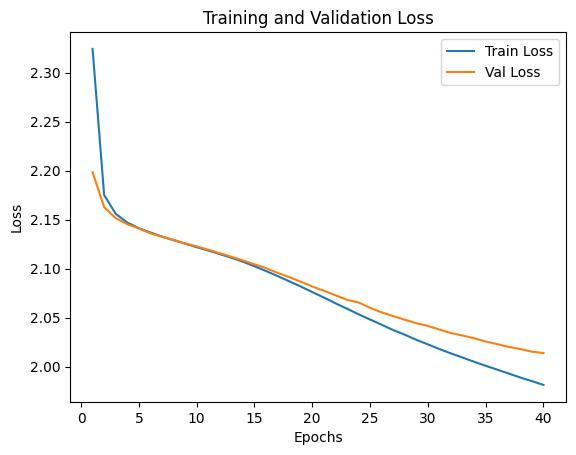

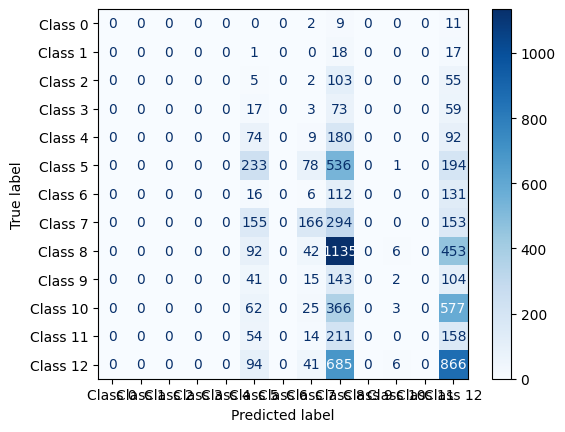

In [470]:
# To start training from scratch
train_model(model, train_iterator, val_iterator)

In [ ]:
# To resume training from a checkpoint
train_model(model, train_iterator, val_iterator, epochs=11, resume=True)